In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.metrics import pairwise_distances
!pip install Levenshtein
from Levenshtein import distance as levenshtein_distance
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 19.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
# Load your data
alpha_chain_data = pd.read_csv('/content/drive/MyDrive/cdr3_alpha_df.csv')
beta_chain_data = pd.read_csv('/content/drive/MyDrive/cdr3_beta_df.csv')
alpha_beta_chain = pd.read_csv('/content/drive/MyDrive/cdr3_alpha_beta_df.csv')

In [42]:
# alpha_chain_data_columns = ['cdr3_a_aa', 'v_a_gene', 'j_a_gene', 'species', 'mhc.a', 'mhc.b', 'mhc.class', 'epitope', 'vdjdb.score']
# alpha_chain_data = alpha_beta_chain[alpha_chain_data_columns].copy()

# beta_chain_data_columns = ['cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'species', 'mhc.a', 'mhc.b', 'mhc.class', 'epitope', 'vdjdb.score']
# beta_chain_data = alpha_beta_chain[beta_chain_data_columns].copy()

# # Save the alpha and beta chain data into separate CSV files if needed
# alpha_chain_data.to_csv('/content/drive/MyDrive/cdr3_alpha_df.csv', index=True)
# beta_chain_data.to_csv('/content/drive/MyDrive/cdr3_beta_df.csv', index=True)

In [44]:
# Function to calculate the pairwise Levenshtein distance matrix
def levenshtein_distance_matrix(sequences):
    length = len(sequences)
    dist_matrix = np.zeros((length, length))
    for i in range(length):
        for j in range(i + 1, length):  # Use symmetry to save computation
            dist = levenshtein_distance(sequences[i], sequences[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    return dist_matrix

In [45]:
# 定义保存函数，使用 DataFrame 来保存 CSV
def save_distance_matrix_to_csv(distance_matrix, filename):
    df = pd.DataFrame(distance_matrix)
    df.to_csv(filename, index=True, header=True)  # 不保存行列的索引

In [58]:
# Extract CDR3 sequences
alpha_homoSapiens_sequences = alpha_chain_data.loc[alpha_chain_data['species'] == 'HomoSapiens', ['cdr3_a_aa', 'v_a_gene', 'j_a_gene']].values.tolist()
alpha_musMusculus_sequences = alpha_chain_data.loc[alpha_chain_data['species'] == 'MusMusculus', ['cdr3_a_aa', 'v_a_gene', 'j_a_gene']].values.tolist()

beta_homoSapiens_sequences = beta_chain_data.loc[beta_chain_data['species'] == 'HomoSapiens', ['cdr3_b_aa', 'v_b_gene', 'j_b_gene']].values.tolist()
beta_musMusculus_sequences = beta_chain_data.loc[beta_chain_data['species'] == 'MusMusculus', ['cdr3_b_aa', 'v_b_gene', 'j_b_gene']].values.tolist()

# alpha_beta_homoSapiens_sequences = [a + b for a, b in zip(
#     alpha_chain_data.loc[alpha_chain_data['species'] == 'HomoSapiens', ['cdr3_a_aa', 'v_a_gene', 'j_a_gene']].values.tolist(),
#     beta_chain_data.loc[beta_chain_data['species'] == 'HomoSapiens', ['cdr3_b_aa', 'v_b_gene', 'j_b_gene']].values.tolist())]

# alpha_beta_musMusculus_sequences = [a + b for a, b in zip(
#     alpha_chain_data.loc[alpha_chain_data['species'] == 'MusMusculus', ['cdr3_a_aa',  'v_a_gene', 'j_a_gene']].values.tolist(),
#     beta_chain_data.loc[beta_chain_data['species'] == 'MusMusculus', ['cdr3_b_aa', 'v_b_gene', 'j_b_gene']].values.tolist())]


alpha_homoSapiens_distance_matrix = levenshtein_distance_matrix(alpha_homoSapiens_sequences)
alpha_musMusculus_distance_matrix = levenshtein_distance_matrix(alpha_musMusculus_sequences)
beta_homoSapiens_distance_matrix = levenshtein_distance_matrix(beta_homoSapiens_sequences)
beta_musMusculus_distance_matrix = levenshtein_distance_matrix(beta_musMusculus_sequences)
# alpha_beta_homoSapiens_distance_matrix = levenshtein_distance_matrix(alpha_beta_homoSapiens_sequences)
# alpha_beta_musMusculus_distance_matrix = levenshtein_distance_matrix(alpha_beta_musMusculus_sequences)

# 保存矩阵到 CSV
save_distance_matrix_to_csv(alpha_homoSapiens_distance_matrix, "/content/drive/MyDrive/alpha_homoSapiens_distance_matrix.csv")
save_distance_matrix_to_csv(alpha_musMusculus_distance_matrix, "/content/drive/MyDrive/alpha_musMusculus_distance_matrix.csv")
save_distance_matrix_to_csv(beta_homoSapiens_distance_matrix, "/content/drive/MyDrive/beta_homoSapiens_distance_matrix.csv")
save_distance_matrix_to_csv(beta_musMusculus_distance_matrix, "/content/drive/MyDrive/beta_musMusculus_distance_matrix.csv")
# save_distance_matrix_to_csv(alpha_beta_homoSapiens_distance_matrix, "/content/drive/MyDrive/alpha_beta_homoSapiens_distance_matrix.csv")
# save_distance_matrix_to_csv(alpha_beta_musMusculus_distance_matrix, "/content/drive/MyDrive/alpha_beta_musMusculus_distance_matrix.csv")

In [66]:
# Compute the distance matrices
# alpha_cdr3_sequences = alpha_homoSapiens_sequences + alpha_musMusculus_sequences
# beta_cdr3_sequences = beta_homoSapiens_sequences + beta_musMusculus_sequences
# alpha_beta_sequences = alpha_beta_homoSapiens_sequences + alpha_beta_musMusculus_sequences

# alpha_distance_matrix = levenshtein_distance_matrix(alpha_cdr3_sequences)
# beta_distance_matrix = levenshtein_distance_matrix(beta_cdr3_sequences)
# alpha_beta_distance_matrix = levenshtein_distance_matrix(alpha_beta_sequences)

alpha_beta_homoSapiens_distance_matrix = alpha_homoSapiens_distance_matrix + beta_homoSapiens_distance_matrix
alpha_beta_musMusculus_distance_matrix = alpha_musMusculus_distance_matrix = beta_musMusculus_distance_matrix

#Save the matrices to CSV files
save_distance_matrix_to_csv(alpha_beta_homoSapiens_distance_matrix, "/content/drive/MyDrive/alpha_beta_homoSapiens_distance_matrix.csv")
save_distance_matrix_to_csv(alpha_beta_musMusculus_distance_matrix, "/content/drive/MyDrive/alpha_beta_musMusculus_distance_matrix.csv")

In [67]:
# Load the distance matrices from CSV files
alpha_homoSapiens_distance_matrix = pd.read_csv("/content/drive/MyDrive/alpha_homoSapiens_distance_matrix.csv")
alpha_musMusculus_distance_matrix = pd.read_csv("/content/drive/MyDrive/alpha_musMusculus_distance_matrix.csv")
beta_homoSapiens_distance_matrix = pd.read_csv("/content/drive/MyDrive/beta_homoSapiens_distance_matrix.csv")
beta_musMusculus_distance_matrix = pd.read_csv("/content/drive/MyDrive/beta_musMusculus_distance_matrix.csv")
alpha_beta_homoSapiens_distance_matrix = pd.read_csv("/content/drive/MyDrive/alpha_beta_homoSapiens_distance_matrix.csv")
alpha_beta_musMusculus_distance_matrix = pd.read_csv("/content/drive/MyDrive/alpha_beta_musMusculus_distance_matrix.csv")

In [68]:
def load_distance_matrix(filename):
    return pd.read_csv(filename, index_col=0)
# load data
alpha_homoSapiens_distance_matrix = load_distance_matrix('/content/drive/MyDrive/alpha_homoSapiens_distance_matrix.csv')
alpha_musMusculus_distance_matrix = load_distance_matrix('/content/drive/MyDrive/alpha_musMusculus_distance_matrix.csv')
beta_homoSapiens_distance_matrix = load_distance_matrix('/content/drive/MyDrive/beta_homoSapiens_distance_matrix.csv')
beta_musMusculus_distance_matrix = load_distance_matrix('/content/drive/MyDrive/beta_musMusculus_distance_matrix.csv')
alpha_beta_homoSapiens_distance_matrix = load_distance_matrix('/content/drive/MyDrive/alpha_beta_homoSapiens_distance_matrix.csv')
alpha_beta_musMusculus_distance_matrix = load_distance_matrix('/content/drive/MyDrive/alpha_beta_musMusculus_distance_matrix.csv')

In [51]:
#Define a dictionary to store matrix names
distance_matrices = [
    (alpha_homoSapiens_distance_matrix, 'alpha_homoSapiens_distance_matrix'),
    (alpha_musMusculus_distance_matrix, 'alpha_musMusculus_distance_matrix'),
    (beta_homoSapiens_distance_matrix, 'beta_homoSapiens_distance_matrix.csv'),
    (beta_musMusculus_distance_matrix, 'beta_musMusculus_distance_matrix.csv'),
    (alpha_beta_homoSapiens_distance_matrix, 'alpha_beta_homoSapiens_distance_matrix'),
    (alpha_beta_musMusculus_distance_matrix, 'alpha_beta_musMusculus_distance_matrix')
    ]

In [52]:
# transform the distance matrix into a condensed distance matrix
# perform hierarchical clustering
for distance_matrix, label in distance_matrices:
    # Convert distance matrix to compressed format
    condensed_dist_matrix = squareform(distance_matrix)

    # Perform hierarchical clustering
    linkage_matrix = linkage(condensed_dist_matrix, method='ward')

    # Create a DataFrame to hold the linkage matrix
    linkage_df = pd.DataFrame(linkage_matrix, columns=['Cluster1', 'Cluster2', 'Distance', 'New Cluster Size'])

    # Save DataFrame as CSV file
    linkage_df.to_csv(f'/content/drive/MyDrive/linkage_matrix_{label}.csv', index=True)

In [69]:
# Load distance matrix
for matrix, label in distance_matrices:
    # Create a clusterer, here using precomputed distances
    clustering = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='complete')
    # Perform clustering
    clustering.fit(matrix)
    # Create a DataFrame to save clustering results
    labels = pd.DataFrame(clustering.labels_, columns=['ClusterLabel'])
    # Save clustering results
    labels.to_csv(f'/content/drive/MyDrive/{label}_labels.csv', index=True)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Calculating silhouette scores for alpha_homoSapiens_distance_matrix
Number of Clusters: 2, Silhouette Score: 0.016384308706048043


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 3, Silhouette Score: 0.009729578225505946
Number of Clusters: 4, Silhouette Score: 0.004485956935891099


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 5, Silhouette Score: 0.001350964036143958
Number of Clusters: 6, Silhouette Score: 0.0036567463388450477


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 7, Silhouette Score: 0.003376881166327847


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 8, Silhouette Score: 0.009122738423309242


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 9, Silhouette Score: 0.0071726624809773515


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 10, Silhouette Score: 0.011824366289119776


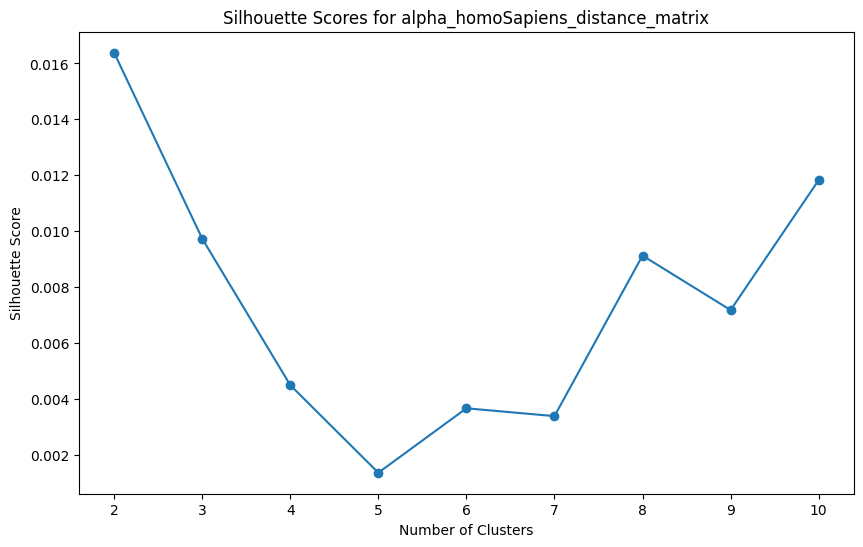

Calculating silhouette scores for alpha_musMusculus_distance_matrix
Number of Clusters: 2, Silhouette Score: 0.03206506647925447
Number of Clusters: 3, Silhouette Score: 0.024978806260228935


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 4, Silhouette Score: 0.02181935093200215
Number of Clusters: 5, Silhouette Score: 0.02018831128792593
Number of Clusters: 6, Silhouette Score: 0.017420472694646413


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 7, Silhouette Score: 0.014928645261007303
Number of Clusters: 8, Silhouette Score: 0.019944877272095627
Number of Clusters: 9, Silhouette Score: 0.03776500409937404


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 10, Silhouette Score: 0.035398327430029526


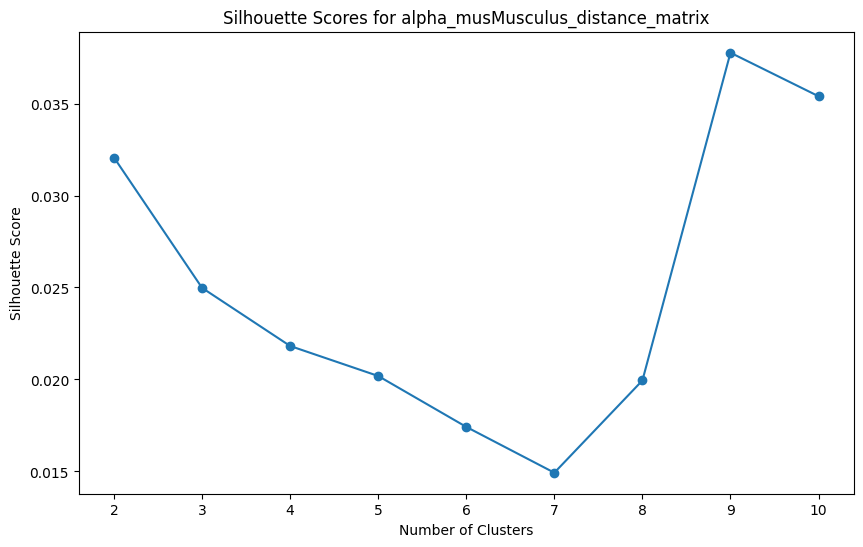

Calculating silhouette scores for beta_homoSapiens_distance_matrix.csv


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 2, Silhouette Score: 0.060618914749133695


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 3, Silhouette Score: 0.09246733088782706


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 4, Silhouette Score: 0.10402849859933773


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 5, Silhouette Score: 0.13300622355264158


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 6, Silhouette Score: 0.16900014398570629


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 7, Silhouette Score: 0.17741837824552448
Number of Clusters: 8, Silhouette Score: 0.20685815340142213


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 9, Silhouette Score: 0.25111673170265514
Number of Clusters: 10, Silhouette Score: 0.24024573821183698


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


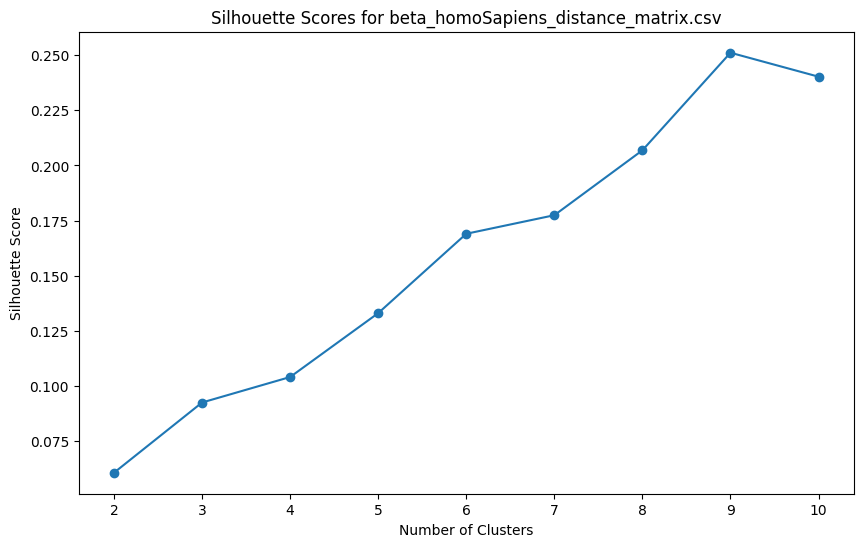

Calculating silhouette scores for beta_musMusculus_distance_matrix.csv
Number of Clusters: 2, Silhouette Score: 0.05950102785552183
Number of Clusters: 3, Silhouette Score: 0.04495550863368233
Number of Clusters: 4, Silhouette Score: 0.07942635032520269
Number of Clusters: 5, Silhouette Score: 0.12782442542196296


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Number of Clusters: 6, Silhouette Score: 0.12414967176776062
Number of Clusters: 7, Silhouette Score: 0.13529250853314564
Number of Clusters: 8, Silhouette Score: 0.15146299126223933
Number of Clusters: 9, Silhouette Score: 0.16272279098273715
Number of Clusters: 10, Silhouette Score: 0.17452117111071463


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


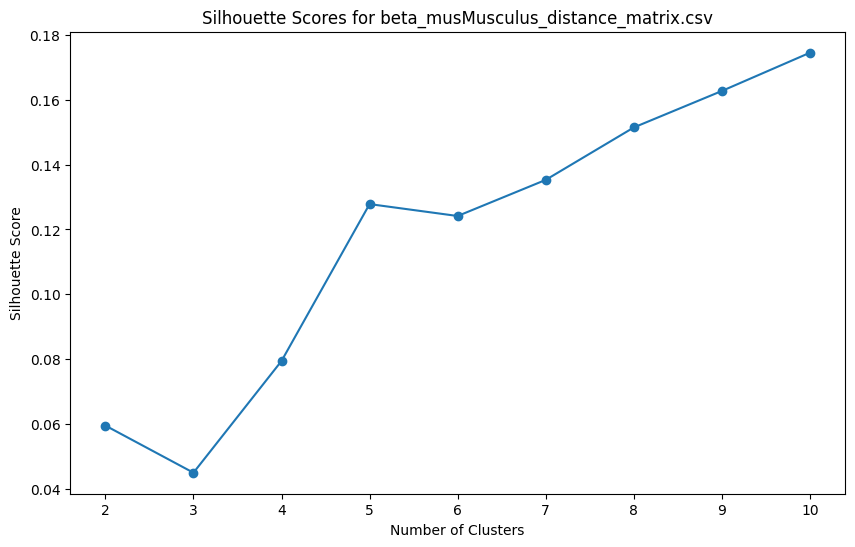

Calculating silhouette scores for alpha_beta_homoSapiens_distance_matrix
Number of Clusters: 2, Silhouette Score: 0.02669430209095628


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 3, Silhouette Score: 0.02914801372313535
Number of Clusters: 4, Silhouette Score: 0.02773814612461952


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 5, Silhouette Score: 0.029259720434432507
Number of Clusters: 6, Silhouette Score: 0.03080072574007411


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 7, Silhouette Score: 0.019332372480616623
Number of Clusters: 8, Silhouette Score: 0.02100275197922114


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Number of Clusters: 9, Silhouette Score: 0.01651016667042929
Number of Clusters: 10, Silhouette Score: 0.014041561212859991


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


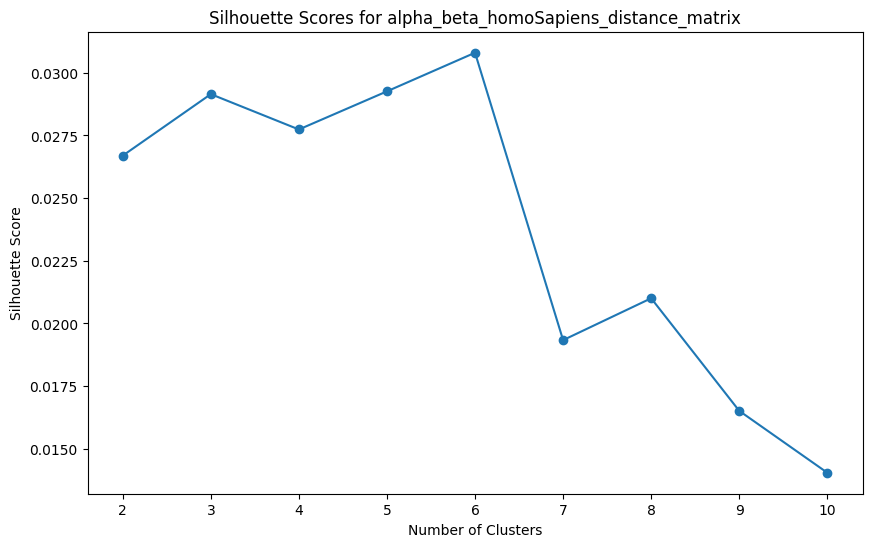

Calculating silhouette scores for alpha_beta_musMusculus_distance_matrix
Number of Clusters: 2, Silhouette Score: 0.03832139289718089
Number of Clusters: 3, Silhouette Score: -0.020772468255405508
Number of Clusters: 4, Silhouette Score: -0.04036972604436992
Number of Clusters: 5, Silhouette Score: -0.030795633414168348


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be

Number of Clusters: 6, Silhouette Score: -0.03423115192492176
Number of Clusters: 7, Silhouette Score: -0.005518554060859496
Number of Clusters: 8, Silhouette Score: -0.008889571817484542
Number of Clusters: 9, Silhouette Score: -0.001212509238398935
Number of Clusters: 10, Silhouette Score: 0.009028193343822691


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


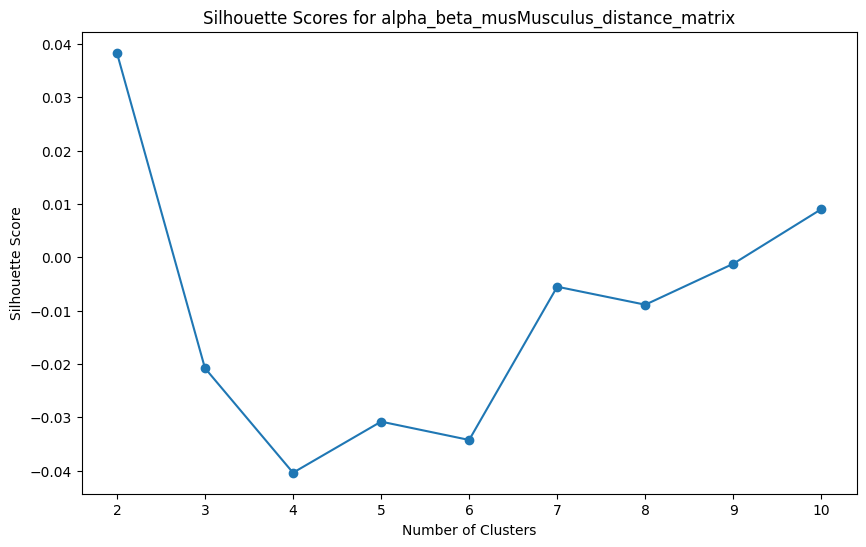

In [70]:
data = distance_matrices

# Loop over each distance matrix and calculate silhouette scores for a range of cluster numbers
for matrix, label in distance_matrices:
    print(f"Calculating silhouette scores for {label}")
    silhouette_scores = []
    cluster_range = range(2, 11)

    # Iterate through the range of cluster numbers
    for n_clusters in cluster_range:
        # Create a clustering instance with the specified number of clusters
        clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='complete')

        # Fit the clustering instance to the data and predict the labels
        labels = clustering.fit_predict(matrix)

        # Calculate the silhouette score for the current number of clusters
        score = silhouette_score(matrix, labels, metric='precomputed')
        silhouette_scores.append(score)
        print(f'Number of Clusters: {n_clusters}, Silhouette Score: {score}')

    # Plot the elbow graph for the current distance matrix
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.title(f'Silhouette Scores for {label}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()